### Import libraries

In [1]:
import sys
import os
import gc
import pandas as pd
from functools import partial
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/machine_learning/scripts/")

In [3]:
from data_set_up import *
from embed_car_price import *
%load_ext autoreload
%autoreload 2

In [4]:
EmbedCarPrice.set_gpu_limit(6)

### Split none onehot encoded data into train,dev and test for categorical embedding

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_merged.csv")
features, y = data.drop("price",axis=1), data.price 

In [6]:
data_setup = DataSetUp(features,y)
X_train,X_dev,X_test,y_train,y_dev,y_test = data_setup.data_split(2020,0.1,True,2020,0.11)

In [7]:
X_train.shape,X_dev.shape,X_test.shape,y_train.shape,y_dev.shape,y_test.shape

((79447, 8), (9820, 8), (9919, 8), (79447,), (9820,), (9919,))

### We will embed columns model, transmission, fuelType, and brand

--- 

### Garbage collect

In [8]:
gc.collect()
%reset -f out

Flushing output cache (1 entries)


### Setting up some constants for base model

In [ ]:
EMBED_COLS = ["model","transmission","brand","fuelType"]
NONEMBED_COLS = [c for c in X_train.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 1e-3
numeric_size = [64,32]
model_size = [1024,512,256]
DROPOUT= [0.2,0.2]
METRICS = ["MAPE","MAE"]

In [9]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

* model embed model input 
* transmission embed model input
* brand embed model input 
* fuelType embed model input 
* numeric input data 

### Perform categorical feature transformation

In [ ]:
data_setup.categorical_mapping(X_train,EMBED_COLS)

In [ ]:
X_train_list,X_dev_list  = data_setup.cate_data_list(X_train),data_setup.cate_data_list(X_dev)
X_test_list,features_list = data_setup.cate_data_list(X_test), data_setup.cate_data_list(features)

In [ ]:
X_train_dataset, X_dev_dataset = (X_train_list,y_train),(X_dev_list,y_dev)

In [ ]:
base_embed_model = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS, 
                                                   X_train,numeric_size,
                                                   model_size,DROPOUT,METRICS,lr)

In [ ]:
carPrice_embed = EmbedCarPrice(base_embed_model,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [ ]:
carPrice_embed.regression_metrics(X_train_list,y_train,"train",True,X_train_dataset,X_dev_dataset,1)

In [ ]:
carPrice_embed.regression_metrics(X_test_list,y_test,"test",False)

In [ ]:
carPrice_embed.save_model("cate_embed_base_model.h5")

In [ ]:
base_embed_model = EmbedCarPrice.load_model("cate_embed_base_model.h5")

In [ ]:
carPrice_embed.plot_pred_price(features_list,y)

In [ ]:
price_table = carPrice_embed.price_diff(features,y,features_list)

In [ ]:
price_table.head(20)

### similar to regular NN

### Let's try a bigger model and see if it helps and increase embed size with slower learning rate 

In [ ]:
EMBED_COLS = ["model","transmission","brand","fuelType"]
NONEMBED_COLS = [c for c in X_train.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [ ]:
bigger_embed_model = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS,
                                                     X_train,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [ ]:
bigger_embed_model.summary()

In [ ]:
carPrice_embed_bigger = EmbedCarPrice(bigger_embed_model,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [ ]:
carPrice_embed_bigger.regression_metrics(X_train_list,y_train,"train",True,X_train_dataset,X_dev_dataset,1)

In [ ]:
carPrice_embed_bigger.regression_metrics(X_test_list,y_test,"test",False)

In [ ]:
carPrice_embed_bigger.save_model("bigger_embed.h5")

In [ ]:
bigger_embed = EmbedCarPrice.load_model("bigger_embed.h5")

In [ ]:
carPrice_embed_bigger.plot_pred_price(features_list,y)

In [ ]:
price_table = carPrice_embed_bigger.price_diff(features,y,features_list)

In [ ]:
price_table.head(20)

### Performance is slightly better but still have bin year and mil category issues. 

### Try embed other binned numerical features and see if the performance improves 

In [ ]:
EMBED_COLS = ["model","transmission","brand","fuelType","binned_year","mil_cat","binned_mpg","engine_binned"]
NONEMBED_COLS = [c for c in features.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [ ]:
data_setup.categorical_mapping(X_train,EMBED_COLS)

In [ ]:
X_train_list,X_dev_list  = data_setup.cate_data_list(X_train),data_setup.cate_data_list(X_dev)
X_test_list,features_list = data_setup.cate_data_list(X_test), data_setup.cate_data_list(features)

In [ ]:
X_train_dataset, X_dev_dataset = (X_train_list,y_train),(X_dev_list,y_dev)

In [ ]:
all_embed_model = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS, 
                                                   X_train,numeric_size,
                                                   model_size,DROPOUT,METRICS,lr,2)

In [ ]:
all_embed_model.summary()

In [ ]:
carPrice_embed_all = EmbedCarPrice(all_embed_model,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [ ]:
carPrice_embed_all.regression_metrics(X_train_list,y_train,"train",True,X_train_dataset,X_dev_dataset,1)

In [ ]:
carPrice_embed_all.regression_metrics(X_test_list,y_test,"test",False)

In [ ]:
carPrice_embed_all.save_model("All_embed.h5")

In [ ]:
all_embed = EmbedCarPrice.load_model("All_embed.h5")

In [ ]:
carPrice_embed_all.plot_pred_price(features_list,y)

In [ ]:
price_table = carPrice_embed_all.price_diff(features,y,features_list)
price_table.head(20)

### Slightly improved, still have same issues with older year. Let's import original raw data

In [10]:
data_raw = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_raw.csv")
features_raw,y_raw = data_raw.drop("price",axis=1),data_raw.price

In [ ]:
data_setup_raw = DataSetUp(features_raw,y_raw)
X_train_raw,X_dev_raw,X_test_raw,y_train_raw,y_dev_raw,y_test_raw = data_setup_raw.data_split(2020,0.1,True,2020,0.11)

In [ ]:
EMBED_COLS = ["model","transmission","brand","fuelType","year"]
NONEMBED_COLS = [c for c in X_train_raw.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [ ]:
data_setup_raw.categorical_mapping(X_train_raw,EMBED_COLS)

In [ ]:
X_train_list_r,X_dev_list_r = data_setup_raw.cate_data_list(X_train_raw),data_setup_raw.cate_data_list(X_dev_raw)
X_test_list_r, features_list_r = data_setup_raw.cate_data_list(X_test_raw),data_setup_raw.cate_data_list(features_raw)

In [ ]:
train_dataset_r,dev_dataset_r = (X_train_list_r,y_train_raw),(X_dev_list_r,y_dev_raw)

In [ ]:
carPrice_embed_raw = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS,X_train_raw,
                                                     numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [ ]:
carPrice_embed_raw.summary()

In [ ]:
carPrice_embed_raw = EmbedCarPrice(carPrice_embed_raw,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [ ]:
carPrice_embed_raw.regression_metrics(X_train_list_r,y_train_raw,"train",True,train_dataset_r,dev_dataset_r,1)

In [ ]:
carPrice_embed_raw.regression_metrics(X_test_list_r,y_test_raw,"test",False)

In [ ]:
carPrice_embed_raw.save_model("model_embed_raw.h5")

In [ ]:
embed_model_r = EmbedCarPrice.load_model("model_embed_raw.h5")

In [ ]:
carPrice_embed_raw.plot_pred_price(features_list_r,y_raw)

In [ ]:
price_table = carPrice_embed_raw.price_diff(features_raw,y_raw,features_list_r)
price_table.head(20)

### Let's use binned numeric data instead of raw numeric value

In [47]:
combined = data.drop("binned_year",axis=1).merge(data_raw["year"],left_index=True,right_index=True)
features_c,y_c = combined.drop("price",axis=1), combined.price

In [12]:
data_setup_c = DataSetUp(features_c,y_c)

In [36]:
X_train_c,X_dev_c,X_test_c,y_train_c,y_dev_c,y_test_c  = data_setup_c.data_split(2020,0.05,True,2020,0.05)

In [61]:
EMBED_COLS = ["model","transmission","brand","fuelType","year","mil_cat","binned_mpg","engine_binned"]
NONEMBED_COLS = [c for c in X_train_c.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [50]:
data_setup_c.categorical_mapping(X_train_c,EMBED_COLS)

In [51]:
X_train_list_c,X_dev_list_c = data_setup_c.cate_data_list(X_train_c), data_setup_c.cate_data_list(X_dev_c)

In [52]:
X_test_list_c,features_list_c = data_setup_c.cate_data_list(X_test_c),data_setup_c.cate_data_list(features_c)

In [53]:
X_train_dataset_c,X_dev_dataset_c = (X_train_list_c,y_train_c),(X_dev_list_c,y_dev_c)

In [62]:
embed_model_c= EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS,X_train_c,
                                               numeric_size,model_size,DROPOUT,
                                               METRICS,lr,2)

In [63]:
embed_model_c.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_105 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_106 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_107 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_108 (InputLayer)          [(None, 1)]          0                                            
___________________________________________________________________________________________

In [58]:
carPriceEmbed_c = EmbedCarPrice(embed_model_c,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [60]:
# carPriceEmbed_c.regression_metrics(X_train_list_c,y_train_c,"train",True,X_train_dataset_c,X_test_dataset_c,1)

In [ ]:
carPriceEmbed_c.regression_metrics(X_test_list_c,y_test_c,"test",False)

In [ ]:
carPriceEmbed_c.save_model("combined_embed_all.h5")

In [ ]:
embed_model_c= EmbedCarPrice.load_model("combined_embed_all.h5")

In [ ]:
carPriceEmbed_c.plot_pred_price(features_list_c,y_c)

In [ ]:
price_table = carPriceEmbed_c.price_diff(features_c,y_c,features_list_c)
price_table.head(20)

### The binned numeric value did better than original numerica data. 

--- 

### Let's focus on binned numeric value with original year embed model and adjust learning rate first 

In [ ]:
learning_rates = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
mdl_setup = partial(EmbedCarPrice.embed_model_setup, EMBED_COLS,NONEMBED_COLS,
                    X_train_c,numeric_size,model_size,DROPOUT,METRICS,embed_size_multiplier=2.0)
EmbedCarPrice.param_search(learning_rates,mdl_setup,X_train_dataset_c,X_dev_dataset_c,1)

### learning rate of 0.001 seems to work the best

### tune embed multiplier

In [22]:
mdl_partial = partial(EmbedCarPrice.embed_model_setup, EMBED_COLS,NONEMBED_COLS,
                    X_train_c,numeric_size,model_size,DROPOUT,METRICS,0.001)

2483/2483 [==============================] - 9s 4ms/step - loss: 24059872.0000 - MAPE: 18.8970 - MAE: 2775.9907 - val_loss: 15577011.0000 - val_MAPE: 13.8997 - val_MAE: 2160.9170


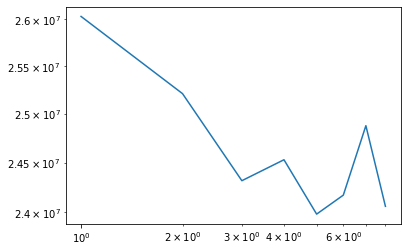

In [23]:
multiplier = [1,2,3,4,5,6,7,8]
EmbedCarPrice.param_search(multiplier,mdl_partial,X_train_dataset_c,X_dev_dataset_c,1)

### multipler of 3 seems to work the best

### increase training size and train on feature set

In [64]:
data_setup_final = DataSetUp(features_c,y_c)

In [65]:
X_train_final,X_test_final,y_train_final,y_test_final = data_setup_final.data_split(2020,0.1)

In [66]:
final_mdl = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS,X_train_final,
                                               numeric_size,model_size,DROPOUT,
                                               METRICS,lr,3)

In [67]:
carPriceEmbed_c_final = EmbedCarPrice(final_mdl,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [69]:
data_setup_final.categorical_mapping(X_train_final,EMBED_COLS)

In [77]:
X_train_final_list = data_setup_final.cate_data_list(X_train_final)
X_test_final_list = data_setup_final.cate_data_list(X_test_final)

In [78]:
train_data_final,test_data_final = (X_train_final_list,y_train_final),(X_test_final_list,y_test_final)

In [70]:
features_list_final = data_setup_final.cate_data_list(features_c)

In [79]:
carPriceEmbed_c_final.regression_metrics(X_train_final_list,y_train_final,
                                        "train",True, train_data_final,test_data_final,1)

Epoch 1/1000
2790/2790 [==============================] - 10s 4ms/step - loss: 6142173.0000 - MAPE: 9.8287 - MAE: 1584.5477 - val_loss: 5407268.5000 - val_MAPE: 9.4166 - val_MAE: 1508.8293
Epoch 2/1000
2790/2790 [==============================] - 10s 4ms/step - loss: 6063200.0000 - MAPE: 9.7387 - MAE: 1570.5397 - val_loss: 5271289.5000 - val_MAPE: 9.9041 - val_MAE: 1509.0293
Epoch 3/1000
2790/2790 [==============================] - 10s 4ms/step - loss: 5923044.0000 - MAPE: 9.6699 - MAE: 1559.0647 - val_loss: 5325721.5000 - val_MAPE: 8.8366 - val_MAE: 1451.4265
Epoch 4/1000
2790/2790 [==============================] - 10s 4ms/step - loss: 5938203.5000 - MAPE: 9.6505 - MAE: 1554.8004 - val_loss: 5877818.0000 - val_MAPE: 9.6954 - val_MAE: 1551.8494
Epoch 5/1000
2790/2790 [==============================] - 10s 4ms/step - loss: 5835687.5000 - MAPE: 9.6152 - MAE: 1545.5900 - val_loss: 5069431.0000 - val_MAPE: 8.8174 - val_MAE: 1428.0948
Epoch 6/1000
2790/2790 [==============================]

2790/2790 [==============================] - 10s 4ms/step - loss: 5081578.0000 - MAPE: 8.9031 - MAE: 1437.3181 - val_loss: 4940877.5000 - val_MAPE: 9.1188 - val_MAE: 1415.0211
Epoch 45/1000
2790/2790 [==============================] - 10s 4ms/step - loss: 5069587.5000 - MAPE: 8.9207 - MAE: 1436.9620 - val_loss: 4775148.0000 - val_MAPE: 8.2995 - val_MAE: 1360.3577
Epoch 46/1000
2790/2790 [==============================] - 10s 4ms/step - loss: 5081316.5000 - MAPE: 8.9437 - MAE: 1441.1140 - val_loss: 4807448.5000 - val_MAPE: 8.6781 - val_MAE: 1375.9934
Epoch 47/1000
2790/2790 [==============================] - 10s 4ms/step - loss: 5052922.5000 - MAPE: 8.9217 - MAE: 1438.0663 - val_loss: 4766802.5000 - val_MAPE: 8.9562 - val_MAE: 1402.4384
Epoch 48/1000
2790/2790 [==============================] - 10s 4ms/step - loss: 5022993.0000 - MAPE: 8.8908 - MAE: 1435.0577 - val_loss: 4898133.0000 - val_MAPE: 8.7594 - val_MAE: 1391.3950
Epoch 49/1000
2790/2790 [==============================] - 10s 4

,r2_score,rmse,price_diff_abs_max
train,0.953947,2122.566497,331.573867


In [ ]:
carPriceEmbed_c_final.regression_metrics(X_test_final,y_test_final,"test",False)

In [80]:
carPriceEmbed_c_final.save_model("final_embed_mdl.h5")

In [ ]:
carPriceEmbed_c_final.plot_pred_price(features_list_final,y_c)

In [ ]:
price_table = carPriceEmbed_c_final.price_diff(features_c,y_c,features_list_final)
price_table.head(20)

### Conclusions

### More tuning on dropout and other params can enhance the models but embed gives the best results